<a href="https://colab.research.google.com/github/ethandavenport/Optimization-I-Project-2/blob/main/Optimization_HW_pt_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 73.3 MB/s eta 0:00:00


In [4]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np

In [5]:
url = "https://raw.githubusercontent.com/ethandavenport/Optimization-I-Project-2/refs/heads/main/roi_company1.csv"
df_roi = pd.read_csv(url)

In [17]:
# Amounts are in MILLIONS of dollars (so budget=10 means $10M)
# --- Parameters (change if needed) ---
budget = 10.0        # total budget in millions
platform_cap = 3.0   # per-platform max in millions
bigM = budget        # big-M for "infinite" tiers (safe because total budget <= budget)

# Compute tier widths (maximum amount that can be placed in that tier)
def tier_width(row):
    if np.isfinite(row['UpperBound']):
        return max(0.0, row['UpperBound'] - row['LowerBound'])
    else:
        return bigM  # allow up to the whole budget for an "infinite" tier; platform cap will restrict
df_roi['Width'] = df_roi.apply(tier_width, axis=1)

# Build model
m = gp.Model()

# Decision vars: amount invested in each tier (millions)
vars_by_index = {}
for idx, row in df_roi.iterrows():
    name = f"x_{int(idx)}_{row['Platform']}_t{int(row['Tier'])}"
    ub = row['Width']
    # some widths could be zero if Upper==Lower; skip creating vars that can't take anything
    if ub <= 0:
        v = m.addVar(lb=0.0, ub=0.0, name=name)
    else:
        v = m.addVar(lb=0.0, ub=ub, name=name)
    vars_by_index[idx] = v


# Objective: maximize total return = sum(ROI * invested_in_tier)
obj_expr = gp.quicksum(df_roi.loc[idx, 'ROI'] * vars_by_index[idx] for idx in vars_by_index)
m.setObjective(obj_expr, GRB.MAXIMIZE)

# 1) Total budget constraint
m.addConstr(gp.quicksum(vars_by_index[idx] for idx in vars_by_index) <= budget)

# Helper: platform -> list of tier indices
platform_to_indices = {}
for idx, row in df_roi.iterrows():
    platform_to_indices.setdefault(row['Platform'], []).append(idx)

# 2) Per-platform cap: total invested in each platform <= platform_cap
for platform, idx_list in platform_to_indices.items():
    m.addConstr(gp.quicksum(vars_by_index[idx] for idx in idx_list) <= platform_cap)

# Business constraints:
# a) Print + TV <= Facebook + Email
def platform_total(platform):
    idxs = platform_to_indices.get(platform, [])
    return gp.quicksum(vars_by_index[i] for i in idxs)

m.addConstr(platform_total('Print') + platform_total('TV') <= platform_total('Facebook') + platform_total('Email'))

# b) Social media (Facebook, LinkedIn, Instagram, Snapchat, Twitter) >= 2 * (SEO + AdWords)
social_platforms = ['Facebook', 'LinkedIn', 'Instagram', 'Snapchat', 'Twitter']
social_sum = gp.quicksum(platform_total(p) for p in social_platforms)
m.addConstr(social_sum >= 2.0 * (platform_total('SEO') + platform_total('AdWords')))

# Solve
m.Params.OutputFlag = 0 # tell gurobi to shut up!!
m.optimize()

# Print results
if m.status == GRB.OPTIMAL or m.status == GRB.TIME_LIMIT or m.status == GRB.SUBOPTIMAL:
    print('\n=== Optimal allocation (amounts in MILLIONS) ===')
    # Per-platform totals
    platform_alloc = {}
    for platform, idxs in platform_to_indices.items():
        total = sum(vars_by_index[i].X for i in idxs)
        platform_alloc[platform] = total
        print(f"{platform:10s}: {total:.4f} (per-tier breakdown below)")
        for i in idxs:
            invested = vars_by_index[i].X
            if invested > 1e-8:
                row = df_roi.loc[i]
                print(f"   tier {int(row['Tier'])}: {invested:.4f}  (ROI={row['ROI']:.4f}, width={row['Width']:.2f})")
    total_invested = sum(v.X for v in vars_by_index.values())
    total_return = sum(df_roi.loc[i, 'ROI'] * vars_by_index[i].X for i in vars_by_index)
    print(f"\nTotal invested: {total_invested:.4f} / {budget:.4f} (M)")
    print(f"Estimated total return: {total_return:.6f} (in MILLIONS of dollars returned)")
    # If you want dollar-level return, multiply by 1e6
else:
    print("Model did not solve to optimality. Status:", m.status)


=== Optimal allocation (amounts in MILLIONS) ===
Print     : 0.0000 (per-tier breakdown below)
TV        : 3.0000 (per-tier breakdown below)
   tier 1: 3.0000  (ROI=0.0608, width=4.30)
SEO       : 0.0000 (per-tier breakdown below)
AdWords   : 1.0000 (per-tier breakdown below)
   tier 1: 1.0000  (ROI=0.0419, width=2.00)
Facebook  : 0.0000 (per-tier breakdown below)
LinkedIn  : 0.0000 (per-tier breakdown below)
Instagram : 3.0000 (per-tier breakdown below)
   tier 1: 2.9000  (ROI=0.0574, width=2.90)
   tier 2: 0.1000  (ROI=0.0498, width=10.00)
Snapchat  : 0.0000 (per-tier breakdown below)
Twitter   : 0.0000 (per-tier breakdown below)
Email     : 3.0000 (per-tier breakdown below)
   tier 1: 3.0000  (ROI=0.0493, width=5.90)

Total invested: 10.0000 / 10.0000 (M)
Estimated total return: 0.543640 (in MILLIONS of dollars returned)


In [24]:
url2 = "https://raw.githubusercontent.com/ethandavenport/Optimization-I-Project-2/refs/heads/main/roi_company2.csv"
df_roi2 = pd.read_csv(url2)

# -----------------------------
# SETUP (amounts in MILLIONS)
# -----------------------------
budget = 10.0        # total budget in millions
platform_cap = 3.0   # per-platform max in millions
bigM = budget        # safe big-M for "inf" tiers

# Ensure Width exists (based on df_roi2)
def tier_width(row):
    if np.isfinite(row['UpperBound']):
        return max(0.0, row['UpperBound'] - row['LowerBound'])
    else:
        return bigM  # allow up to whole budget for "inf"
df2 = df_roi2.copy()
df2['Width'] = df2.apply(tier_width, axis=1)

# -----------------------------
# BUILD MODEL FROM df_roi2 ONLY
# -----------------------------
m_mip = gp.Model() # Use a different model name for MIP
m_mip.Params.OutputFlag = 0

# Decision vars: amount invested in each tier (millions)
vars_by_index_mip = {} # Use a different variable name for MIP vars
for idx, row in df2.iterrows():
    name = f"x_{int(idx)}_{row['Platform']}_t{int(row['Tier'])}"
    ub = float(row['Width'])
    # keep same pattern as your LP
    if ub <= 0:
        v = m_mip.addVar(lb=0.0, ub=0.0, name=name)
    else:
        v = m_mip.addVar(lb=0.0, ub=ub, name=name)
    vars_by_index_mip[idx] = v

# Objective: maximize total return = sum(ROI * invested_in_tier)
obj_expr = gp.quicksum(df2.loc[idx, 'ROI'] * vars_by_index_mip[idx] for idx in vars_by_index_mip)
m_mip.setObjective(obj_expr, GRB.MAXIMIZE)

# Helper: platform -> list of tier indices (built from df_roi2)
platform_to_indices_mip = {} # Use a different name for MIP indices
for idx, row in df2.iterrows():
    platform_to_indices_mip.setdefault(row['Platform'], []).append(idx)

# -----------------------------
# SAME BUSINESS CONSTRAINTS
# -----------------------------
# 1) Total budget
m_mip.addConstr(gp.quicksum(vars_by_index_mip[idx] for idx in vars_by_index_mip) <= budget)

# 2) Per-platform cap
for platform, idx_list in platform_to_indices_mip.items():
    m_mip.addConstr(gp.quicksum(vars_by_index_mip[idx] for idx in idx_list) <= platform_cap)

# (a) Print + TV <= Facebook + Email
def platform_total_mip(p): # Use a different name for MIP platform total
    idxs = platform_to_indices_mip.get(p, [])
    return gp.quicksum(vars_by_index_mip[i] for i in idxs)

m_mip.addConstr(
    platform_total_mip('Print') + platform_total_mip('TV')
    <= platform_total_mip('Facebook') + platform_total_mip('Email')
)

# (b) Social >= 2 * (SEO + AdWords)
social_platforms = ['Facebook', 'LinkedIn', 'Instagram', 'Snapchat', 'Twitter']
social_sum = gp.quicksum(platform_total_mip(p) for p in social_platforms)
m_mip.addConstr(social_sum >= 2.0 * (platform_total_mip('SEO') + platform_total_mip('AdWords')))

# -----------------------------
# MIP ADD-ON: NO SKIPPING
# -----------------------------
# 1) Binary activation per tier
z_by_index = {}
for idx, row in df2.iterrows():
    z_by_index[idx] = m_mip.addVar(vtype=GRB.BINARY,
                               name=f"z_{int(idx)}_{row['Platform']}_t{int(row['Tier'])}")

# 2) Gate: no spend unless tier is on
for idx, row in df2.iterrows():
    m_mip.addConstr(vars_by_index_mip[idx] <= row['Width'] * z_by_index[idx],
                name=f"gate_{int(idx)}_{row['Platform']}_t{int(row['Tier'])}")

# 3) Chain (no activation skipping): if higher tier is on, lower must be on  -> z_prev >= z_next
for platform, idx_list in platform_to_indices_mip.items(): # Use platform_to_indices_mip
    idx_list_sorted = sorted(
        idx_list,
        key=lambda k: (float(df2.loc[k, 'LowerBound']), int(df2.loc[k, 'Tier']))
    )
    for prev_idx, next_idx in zip(idx_list_sorted[:-1], idx_list_sorted[1:]):
        m_mip.addConstr(z_by_index[prev_idx] >= z_by_index[next_idx],
                    name=f"order_{platform}_t{int(df2.loc[prev_idx,'Tier'])}_to_t{int(df2.loc[next_idx,'Tier'])}")

# 4) Fill-up (no spend skipping): must fully fund tier j before any spend in tier j+1
for platform, idx_list in platform_to_indices_mip.items(): # Use platform_to_indices_mip
    idx_list_sorted = sorted(
        idx_list,
        key=lambda k: (float(df2.loc[k, 'LowerBound']), int(df2.loc[k, 'Tier']))
    )
    for prev_idx, next_idx in zip(idx_list_sorted[:-1], idx_list_sorted[1:]):
        m_mip.addConstr(
            vars_by_index_mip[prev_idx] >= df2.loc[prev_idx, 'Width'] * z_by_index[next_idx],
            name=f"fill_{platform}_t{int(df2.loc[prev_idx,'Tier'])}_before_t{int(df2.loc[next_idx,'Tier'])}"
        )



# -----------------------------
# SOLVE + CLEAN REPORT
# -----------------------------
m_mip.optimize()

EPS = 1e-9
print(f"Objective (total return): {m_mip.objVal:,.6f}")
for platform, idx_list in platform_to_indices_mip.items(): # Use platform_to_indices_mip
    invested = sum(vars_by_index_mip[i].X for i in idx_list)
    tiers_on = sorted([int(df2.loc[i, 'Tier']) for i in idx_list if vars_by_index_mip[i].X > EPS])
    print(f"{platform:12s}  invested={invested:,.3f}M   tiers_on={tiers_on}")

Objective (total return): 0.452827
Print         invested=3.000M   tiers_on=[1, 2]
TV            invested=0.000M   tiers_on=[]
SEO           invested=0.000M   tiers_on=[]
AdWords       invested=2.333M   tiers_on=[1, 2]
Facebook      invested=3.000M   tiers_on=[1]
LinkedIn      invested=1.667M   tiers_on=[1]
Instagram     invested=0.000M   tiers_on=[]
Snapchat      invested=0.000M   tiers_on=[]
Twitter       invested=0.000M   tiers_on=[]
Email         invested=0.000M   tiers_on=[]


In [25]:
# Scenario 1: Objective using df_roi with allocation from df_roi2 (MIP)

# Get allocation from the MIP model (vars_by_index_mip)
# Use the platform_to_indices_mip created for df_roi2 in cell 33aHki4hS7_s
# Ensure cell 33aHki4hS7_s has been executed to define vars_by_index_mip and platform_to_indices_mip
mip_allocation = {df2.loc[idx, 'Platform']: {df2.loc[idx, 'Tier']: var.X for idx, var in vars_by_index_mip.items() if var.X > 1e-9}
                  for platform, idx_list in platform_to_indices_mip.items()}

# Calculate objective using df_roi and mip_allocation
total_return_roi1_mip_alloc = 0
for idx, row in df_roi.iterrows():
    platform = row['Platform']
    tier = row['Tier']
    roi = row['ROI']
    # Find the allocated amount for this tier in the MIP allocation
    allocated_amount = mip_allocation.get(platform, {}).get(tier, 0)
    total_return_roi1_mip_alloc += roi * allocated_amount

print(f"Objective using df_ROI with allocation from df_ROI2 (MIP): {total_return_roi1_mip_alloc:,.6f}")

# Scenario 2: Objective using df_roi2 with allocation from df_roi (LP)

# Get allocation from the LP model (vars_by_index_lp)
# Use the platform_to_indices_lp created for df_roi in cell Zb0hiaVdjlB6
# Ensure cell Zb0hiaVdjlB6 has been executed to define vars_by_index_lp and platform_to_indices_lp
lp_allocation = {df_roi.loc[idx, 'Platform']: {df_roi.loc[idx, 'Tier']: var.X for idx, var in vars_by_index.items() if var.X > 1e-9}
                 for platform, idx_list in platform_to_indices.items()}

# Calculate objective using df_roi2 and lp_allocation
total_return_roi2_lp_alloc = 0
for idx, row in df_roi2.iterrows():
    platform = row['Platform']
    tier = row['Tier']
    roi = row['ROI']
    # Find the allocated amount for this tier in the LP allocation
    allocated_amount = lp_allocation.get(platform, {}).get(tier, 0)
    total_return_roi2_lp_alloc += roi * allocated_amount

print(f"Objective using df_ROI2 with allocation from df_ROI (LP): {total_return_roi2_lp_alloc:,.6f}")

Objective using df_ROI with allocation from df_ROI2 (MIP): 0.128067
Objective using df_ROI2 with allocation from df_ROI (LP): 0.076150


Graphs for Report

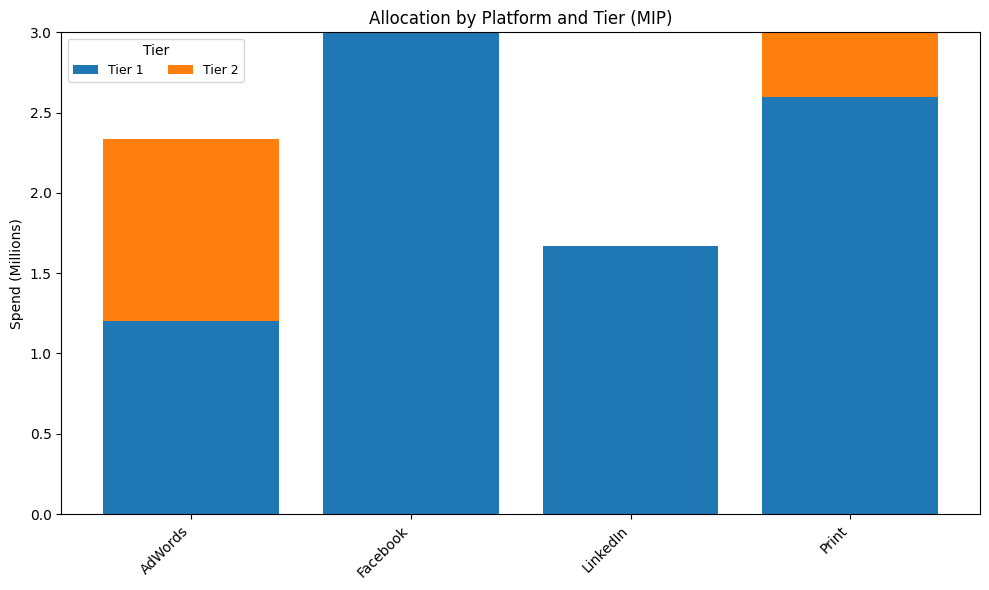


Allocation summary (for report):


,TotalSpendM,TiersOn
Platform,,
AdWords,2.333333,"[1, 2]"
Facebook,3.000000,[1]
LinkedIn,1.666667,[1]
Print,3.000000,"[1, 2]"


In [23]:
# -----------------------------
# GRAPH: Spend by Tier per Platform (stacked bars)
# -----------------------------
import matplotlib.pyplot as plt

EPS = 1e-9

# Build a tidy allocation table from the solved model
alloc_rows = []
for platform, idx_list in platform_to_indices.items():
    for i in idx_list:
        spend = float(vars_by_index_mip[i].X)
        if spend > EPS:
            alloc_rows.append({
                "Platform": platform,
                "Tier": int(df2.loc[i, "Tier"]),
                "SpendM": spend,
                "ROI": float(df2.loc[i, "ROI"])
            })

alloc_df = pd.DataFrame(alloc_rows)

# If nothing was invested (edge case), still create an empty frame
if alloc_df.empty:
    alloc_df = pd.DataFrame(columns=["Platform", "Tier", "SpendM", "ROI"])

# Pivot to Platform x Tier for stacked plotting
spend_pivot = (
    alloc_df
    .pivot_table(index="Platform", columns="Tier", values="SpendM", aggfunc="sum", fill_value=0.0)
    .sort_index(axis=1)  # sort tiers ascending for consistent stacked order
    .sort_index(axis=0)  # sort platforms alphabetically
)

# Plot stacked bars
plt.figure(figsize=(10, 6))
bottom = np.zeros(len(spend_pivot))
x = np.arange(len(spend_pivot.index))
for tier in spend_pivot.columns:
    heights = spend_pivot[tier].values
    plt.bar(x, heights, bottom=bottom, label=f"Tier {tier}")
    bottom += heights

plt.xticks(x, spend_pivot.index, rotation=45, ha="right")
plt.ylabel("Spend (Millions)")
plt.title("Allocation by Platform and Tier (MIP)")
plt.legend(title="Tier", ncols=3, fontsize=9, title_fontsize=10)
plt.tight_layout()
# Optional: save for the report
# plt.savefig("allocation_by_platform_tiers.png", dpi=200, bbox_inches="tight")
plt.show()

# -----------------------------
# TABLE: Totals & Active Tiers (for report appendix)
# -----------------------------
totals = spend_pivot.sum(axis=1).rename("TotalSpendM")
active_tiers = (
    (spend_pivot > EPS)
    .apply(lambda row: [int(c) for c in spend_pivot.columns[row.values]], axis=1)
    .rename("TiersOn")
)
summary_tbl = pd.concat([totals, active_tiers], axis=1)
print("\nAllocation summary (for report):")
display(summary_tbl)
